# CS5950/CS4950/CS3950 Course Project

This project recaps and systematises work that has been done in the exercise notebooks: if you have worked through the notebooks, little extra work is required.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model.

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.)

Please complete this workbook and submit it on Moodle together with answers for other questions, with all outputs (numbers and graphs) visible and included.

Please write your student number **here** 101008860:     
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...)

## Set up dataset

You may choose any of the datasets included with Pytorch, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples).

A more interesting choice would be CIFAR-10

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline


# IMPORTANT

after many experiment the best set up on the system is as follow:

* training set size 2000(as default) and validation set(1000).

* I have trained my models with a maximum of 50 ephoch.


THIS CHOICE WAS TOOK DUE TO THE POOR PERFORMANCE OF MY COMPUTER.



In [2]:
#amount dataset and ephocs

epochsDimention = 50
dataDimention = 2000


In [3]:
########
#THIS IS THE DATASET
########


def dataset(dataSize):

    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))])

        # Load full MNIST dataset
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_trainset_small =  [ train_dataset[i] for i in range(0,dataSize) ]

    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    mnist_testset_small =[mnist_testset[i] for i in range(0,1000) ]


    train_loader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=4, shuffle=True)
    val_loader = torch.utils.data.DataLoader( mnist_testset_small, batch_size=4, shuffle=True)


    return train_loader, val_loader


In [4]:
dataset(dataDimention)

(<torch.utils.data.dataloader.DataLoader at 0x1aeb5e82d50>,
 <torch.utils.data.dataloader.DataLoader at 0x1aeb5ec9a90>)

In [5]:
#######
#TRHIS IS Q1 LOSS
######

#this function compute thre loss and error rate of the training set and validation set.
#the result of this fuction is used to plot the graph of loss training loss and validatiopn loss.


def lossCalculation(model,train_loader,val_loader,num_epochs,loss_Funciton,optimizer): 
    #num_epochs = 100
    train_losses, val_losses = [], []
    train_errors, val_errors = [], []
    for epoch in range(num_epochs):
        # Training
        
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_Funciton(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_losses.append(train_loss / len(train_loader))
        train_errors.append(1 - correct_train / total_train)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_Funciton(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_losses.append(val_loss / len(val_loader))
        val_errors.append(1 - correct_val / total_val)
        #print(model)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Error: #{train_errors[-1]:.4f}, Val Error: {val_errors[-1]:.4f}")
    return train_losses,val_losses


In [6]:
######
#THIS IS Q2 LOSS CALCULATION
#####

#this function compute the errror rate with different parameter of regularization.
#The regularization used is L2 regularization.
#The result of this function is used to plot the graph of error rate with different regularization parameter.

def lossCalculation2(mm,train_loader,val_loader,num_epochs):  # ADD MODEL

    weight_decay_values =[0, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1] ### change the parameter
    results = {}
    avg_val_losses = {}  # Store average validation losses
    val_error_rate_epoch = []   #store val_error for epoch
    result_val_error_wd = {}    #store val_erro for eight_decay
    #best_weight_dacay = 0

    
    #loops through differetn weight decay value
    for wd in weight_decay_values:
        #print(f"Training with weight decay = {wd}")

        # Initialize model and optimizer
        model = mm       ##GENERALIZE MODEL
        #print(model)

        #weight_decay = L2 regualrization 
        #lr = learing rate to reduce the instability

        optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay=wd)  # L2 regularization   ##### GENERALIZE MODEL
        #print(optimizer)

        # Define loss function
        loss_Funciton = nn.CrossEntropyLoss()
        #print("ciao",num_epochs)
        #num_epochs = 5  # Reduce for faster experimentation
        train_losses, val_losses = [], []

        for epoch in range(num_epochs):
            # Training
            model.train()      #### GENERALIZE MODEL
            train_loss = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)   ##GENERALIZE MODEL
                loss = loss_Funciton(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_losses.append(train_loss / len(train_loader))

            # Validation
            model.eval()           #GENERALIZE MODEL
            val_loss = 0.0       
            correct, total = 0.0, 0.0  #inizialize correct prediction and the number of labels.
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)        #DGENERALIZE MODEL
                    loss = loss_Funciton(outputs, labels)
                    val_loss += loss.item()

                    #compute Error Rate
                    _,predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item() #count the correct prediction

            val_losses.append(val_loss / len(val_loader))
            #val_error_rate_epoch.append( 1 - (correct / total))

            #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        # Store results for plotting
        results[wd] = val_losses
        

        #store the error rate of each traininig size
        #result_val_error_wd[wd] = val_error_rate_epoch 

        # Compute the average validation loss over the last `last_n_epochs` epochs
        avg_val_losses[wd] = np.mean(val_losses[-1:])
    #print('avg_val_loss', avg_val_losses)
    best_weight_dacay = min(avg_val_losses,key=avg_val_losses.get)
    best_value_loss = avg_val_losses[best_weight_dacay]   
    #print("min from print",min(avg_val_losses,key=avg_val_losses.get))


    return train_losses,val_losses,results,result_val_error_wd,avg_val_losses,best_weight_dacay,best_value_loss



In [7]:
#########
#THIS IS Q3 ERROR RATE 
######

#this function the error rate.
#this fuction will be used with and another one to plot log-log graph.


def calculationErrorRate3(mm,train_loader,val_loader,num_epochs, wd):

    
    results = {}
    avg_val_losses = {}  # Store average validation losses
    val_error_rate_epoch = []   #store val_error for epoch
    result_val_error_wd = {}    #store val_erro for eight_decay
    


    # Initialize model and optimizer
    model = mm
    #print(model)

    #weight_decay = L2 regualrization 
    #lr = learing rate to reduce the instability

    optimizer = optim.Adam(model.parameters(),lr = 0.0005, weight_decay=wd)  # L2 regularization
    #print(optimizer)

    # Define loss function
    loss_Funciton = nn.CrossEntropyLoss()
    #print("ciao",num_epochs)
    #num_epochs = 5  # Reduce for faster experimentation
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_Funciton(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0.0, 0.0  #inizialize correct prediction and the number of labels.
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = loss_Funciton(outputs, labels)
                val_loss += loss.item()

                #compute Error Rate
                _,predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item() #count the correct prediction

        val_losses.append(val_loss / len(val_loader))
        val_error_rate_epoch.append( 1 - (correct / total))

        #print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Store results for plotting
    results[wd] = val_losses
    

    #store the error rate of each traininig size
    #average error rate of validation set of each epoch.
    result_val_error_wd[wd] = np.mean(val_error_rate_epoch[-1:]) 
    #rint(result_val_error_wd)
    # Compute the average validation loss over the last `last_n_epochs` epochs
    #avg_val_losses[wd] = np.mean(val_losses[4:])
    #print('avg_val_loss', avg_val_losses)


    return train_losses,val_losses,results,result_val_error_wd






###  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate).

In [8]:
#########
#THIS IS FIRST MODEL
##########

#this model is a very simple model with only one layer.
class MODEL1( nn.Module ):
    
    def __init__(self): 
        super(MODEL1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(784,10)
            ) 
    
    
    def forward( self, x ): 
        x = self.layers( x )
        return x
    

model1 = MODEL1()

In [9]:
##
#loss function
loss_Funciton = nn.CrossEntropyLoss()


Epoch 1/50, Train Loss: 1.0047, Val Loss: 0.7124, Train Error: #0.2450, Val Error: 0.1790
Epoch 2/50, Train Loss: 0.4897, Val Loss: 0.5635, Train Error: #0.1190, Val Error: 0.1600
Epoch 3/50, Train Loss: 0.3889, Val Loss: 0.5033, Train Error: #0.0950, Val Error: 0.1460
Epoch 4/50, Train Loss: 0.3314, Val Loss: 0.4725, Train Error: #0.0890, Val Error: 0.1520
Epoch 5/50, Train Loss: 0.2911, Val Loss: 0.4595, Train Error: #0.0785, Val Error: 0.1400
Epoch 6/50, Train Loss: 0.2647, Val Loss: 0.4440, Train Error: #0.0620, Val Error: 0.1380
Epoch 7/50, Train Loss: 0.2392, Val Loss: 0.4231, Train Error: #0.0605, Val Error: 0.1350
Epoch 8/50, Train Loss: 0.2209, Val Loss: 0.4260, Train Error: #0.0535, Val Error: 0.1320
Epoch 9/50, Train Loss: 0.2002, Val Loss: 0.4434, Train Error: #0.0475, Val Error: 0.1360
Epoch 10/50, Train Loss: 0.1885, Val Loss: 0.4401, Train Error: #0.0455, Val Error: 0.1370
Epoch 11/50, Train Loss: 0.1745, Val Loss: 0.4249, Train Error: #0.0425, Val Error: 0.1290
Epoch 12

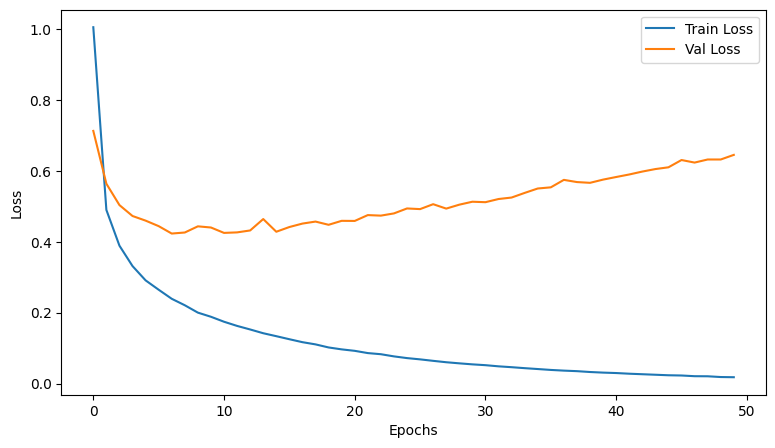

In [10]:
########
#THIS IS Q1 PLOT   
######

#this cell plot the graph of training loss and validation loss.


train_loader, val_loader = dataset(dataDimention)
model1 = MODEL1()
optimizer = optim.Adam(model1.parameters())
train_losses,val_losses = lossCalculation(model1,train_loader,val_loader,epochsDimention,loss_Funciton,optimizer)

plt.figure(figsize=(20, 5))
# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


### 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, or dropout) and train your initial model with different amounts of regularisation.

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse.

Train your model multiple times, applying different amounts of regularisation, and plot a graoph showing the effect of different amounts of regularisation.

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount?

the best decay from Model 1 0.001
the best VALUE LOSS from Model 1 0.4749880684874952


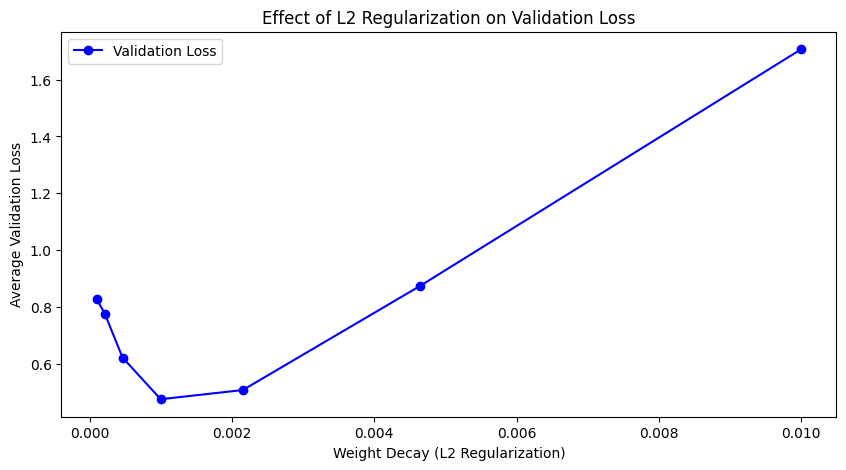

In [11]:
#####
#QTHIS IS Q2 POSS.
#####

#this cell plot the graph of validation error rate with different regularization parameter.

train_loader, val_loader = dataset(dataDimention)
modle1 = MODEL1() 
train_losses, val_lo, results, result_val_error_wd, avg_val_losses, best_weight_dacay1,best_value_loss = lossCalculation2(model1,train_loader, val_loader, epochsDimention)

# Plot results
plt.figure(figsize=(10, 5))

# Extract x and y values
weight_decay_values = avg_val_losses.keys()  # X-axis: Weight decay values
avg_validation_lossesM1 = avg_val_losses.values()  # Y-axis: Average validation loss
#print("key ",weight_decay_values)
#print("value ",avg_validation_losses)

#lambda regularization
w = [0.0001000,0.0002154,0.0004642,0.0010000,0.0021544,0.0046416,0.0100000]


# Plot the graph
plt.plot(w, avg_validation_lossesM1, marker='o', linestyle='-', color='b', label="Validation Loss")


#print the best weight decay.
print(f"the best decay from Model 1 {best_weight_dacay1}") 
#print(f"the best weight_decay after plot graph",best_weight_dacay) 
print(f"the best VALUE LOSS from Model 1 {best_value_loss}")    


# Labels and title
plt.xlabel("Weight Decay (L2 Regularization)")
plt.ylabel("Average Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")

# Show legend and grid
plt.legend()

# Display the plot
#plt.show()

## Answer Q2

 
The regualarization is used to prevent overfitting adding penalty to the weight. 
 
In my project I chose the L2 regularization with 7 different lambda parameter [0,0.00001,0.0001,0.001,0.01,0.1,1].


All the results of the different test are been plotted on the graph. As you can see at lambda 0.0 until lambda 0.001 the value of loss keep reducing ana from 0.001 to 1 the average loss keep encreasing.  THIS MAKE SENSE AS THAT BEST PARAMETER OF L2 USULLY ARE BETWEEN 0.001 AND 0.01. 


CONCLUSION:
model the best parameter is 0.001. and best VALUE LOSS 0.48467970093898477.



# IMPORTANT

as you can see, the x-axes graph the value of weight decay are from 0.0 to 0.01. WELL THOSE VALUES DO NOT REFLECT THE REAL WEIGHT DECAY USED ON THE CALCULATION OF THE LAMBDA. I TOOK THIS CHOICE BECAUSE I BETWEEN 0.0 AND 0.001 THE RESULTS ON THE GRAPH WOULD SHRIMK ALL TOGHETHER, COMPROMISING THEIR READIBILITY. 

THE FUNCTION lossCalculation2(mm,train_loader,val_loader,num_epochs): CAN CONFIRMED THE I USED THE FOLLOW: [0,0.00001,0.0001,0.001,0.01,0.1,1].







### 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data.

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set.
This is typically best done on a log-log plot.

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ?

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is.

## Set up model

Set up a Pytorch model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000).


Plot the loss and error rate as a function of training epochs.


dataSize  500
dataSize  1000
dataSize  2000
dataSize  4000
dataSize  8000
dataSize  16000
dataSize  32000
The most powerfull dataSize 32000


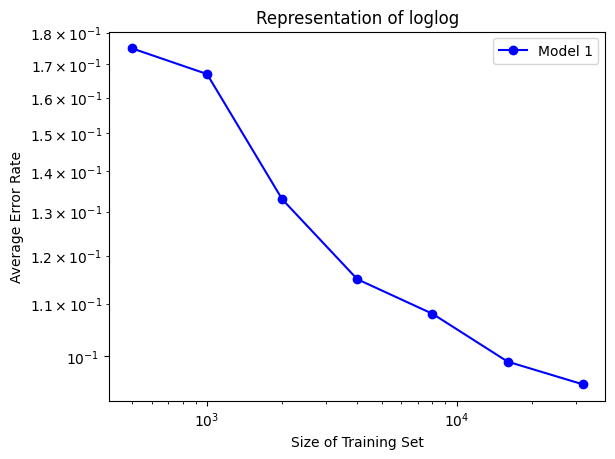

In [12]:
#######
#THIS IS Q3 PLOT ERROR RATE(LOG)
#######
# your code here

array = []
data_Size = [500,1000,2000,4000,8000,16000,32000]
count = 0
dist = []
model1 = MODEL1()
#print(f"best decay in questiuon 3: {best_weight_dacay}")
for dt in data_Size:
    num_epochs = epochsDimention
    train_loader, val_loader = dataset(dt)
    print("dataSize ",dt)
    train_losses,val_losses,results,result_val_error_wd = calculationErrorRate3(modle1,train_loader,val_loader,num_epochs,best_weight_dacay1)
    tmp=list(result_val_error_wd.values())[0]  # Extracts the first (and only) value
    array.append(tmp) # add ina array list


#print("list",array)  # Y-axis: Average validation loss
indMin = np.where(array == np.min(array))[0]  # Get indices of min value
n = indMin[0]
#print("THE Min index",indMin[0])
print("The most powerfull dataSize",data_Size[n])

#evaluating the performance by 1/ np.sqrt(dataSize)
for i in range(len(array)):
    power = 1/np.sqrt(data_Size[i])
    if(power == array[i]):
        print("most powerFull", array[i])
    else:
        #dist.append(np.abs(power - array[i]))
        continue
        #print("no equal: ",power)

# Plot the graph
plt.loglog(data_Size, array, marker='o', linestyle='-', color='b', label="Model 1")


# Labels and title
plt.xlabel("Size of Training Set")
plt.ylabel("Average Error Rate")
plt.title("Representation of loglog")

# Show legend and grid
plt.legend()




## Answer Q3


the approximate relationship  training set and error rate aim to evaluate different level of overfitting of a model in respect with the the dimention of training set. If an model reduce the error-rate at increasing the dimention of datasize that suggest the the model is reducting its overfitting increasing the generalization. 

In base of my understarstanding  the graph show the model reduce the  overfitting at increasing of trainig set(in term of size). However, there is some inconstistency in term(overfitting and dimention training set) between 1000 data and 2000 data. in those case model seem little bit instable(error rate goes up and down). I think the this happen becasue the model is still suffering of overfitting due to the poverty sample.

However, as you can se from the graph the 32000 is the dataset  with most powerfull improvement, in temr of smalleset error-rate.


CONCLUSION:


In my situation the most powerfull is the 32000 dataset. 
Unfortunally, this can not e confirmed using the relation $\dfrac{1}{\sqrt{n}}$ as i did not find any model which performed good enough to reach an exact match(i added code to check).
 


### 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [13]:
class MODLE2(nn.Module):
    def __init__(self):
        super(MODLE2, self).__init__()
        self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),  # Hidden layer with 128 neurons
        nn.ReLU(),
        nn.Linear(128, 10))  
    
    def forward( self, x ): # computes the forward pass ... this one is particularly simple
        x = self.layers( x )
        return x


In [14]:
n2 = MODLE2()
print(n2)

MODLE2(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [15]:
loss_Funciton = nn.CrossEntropyLoss()

optimizer = optim.Adam(MODLE2().parameters())
#print(optimizer)

In [16]:
#model2

## import thig to do. the funciton must return also the best weigh_decay with the best validation loss.

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data).

the best decay from Model 1 0.001
the best weight_decay from Model 2 0.001
the best VALUE LOSS form Model 1 0.4749880684874952
the best VALUE LOSS from Model 2 0.31750530023977624


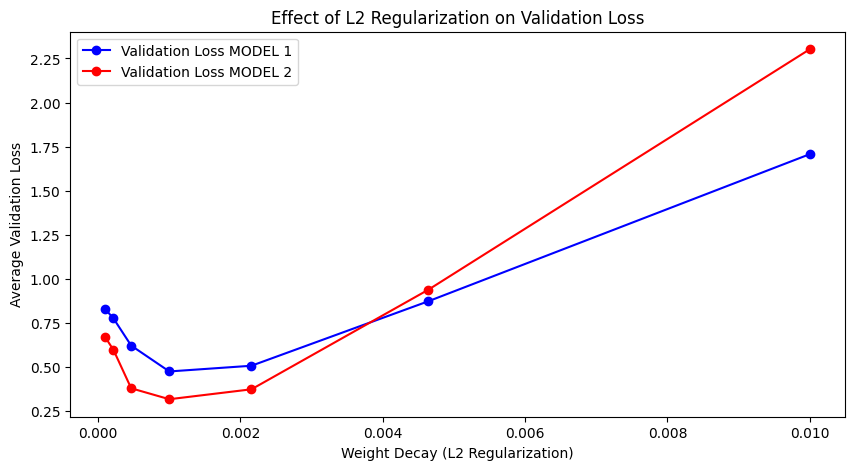

In [17]:
#####
#THIS IS Q4 LOSS PLOT OF MODEL 1 AND MODEL 2
######

#this cell compute the erorr rate in respect of different regualarization parameter. the regualarization used is L2 regularization.
#the result of this function is used to plot the graph of error rate with different regularization parameter.
#this computation is make on the model 2 and the result is ploted with the result of model 1.

train_loader2, val_loader2 = dataset(dataDimention)
modle2 = MODLE2() 
train_losses2, val_lo2, results2, result_val_error_wd2, avg_val_losses2, best_weight_dacay2,best_value_loss2 = lossCalculation2(modle2,train_loader2, val_loader2, epochsDimention)

# Plot results
plt.figure(figsize=(10, 5))

# Extract x and y values
weight_decay_values2 = avg_val_losses2.keys()  # X-axis: Weight decay values
avg_validation_lossesM2 = avg_val_losses2.values()  # Y-axis: Average validation loss
#print("key ",weight_decay_values)
#print("value ",avg_validation_losses)

#lambda regularizations
w = [0.0001000,0.0002154,0.0004642,0.0010000,0.0021544,0.0046416,0.0100000]


# Plot the graph
plt.plot(w, avg_validation_lossesM1, marker='o', linestyle='-', color='b', label="Validation Loss MODEL 1")
plt.plot(w, avg_validation_lossesM2, marker='o', linestyle='-', color='r', label="Validation Loss MODEL 2")


#ADD THE BEST 

print(f"the best decay from Model 1 {best_weight_dacay1}") 
print(f"the best weight_decay from Model 2",best_weight_dacay2)

print(f"the best VALUE LOSS form Model 1 {best_value_loss}")
print(f"the best VALUE LOSS from Model 2 {best_value_loss2}") 


# Labels and title
plt.xlabel("Weight Decay (L2 Regularization)")
plt.ylabel("Average Validation Loss")
plt.title("Effect of L2 Regularization on Validation Loss")

# Show legend and grid
plt.legend()

# Display the plot
#plt.show()


# Answer Q4 part 1

As you can see from the result on my graph the model 2(error rate = 0.31750530023977624) has an error rate less than the model 1(error rate = 0.4749880684874952). 
This inidcating the model 2 perform better than the model 1.


In addtion both models have the same 0.001 lambda (L2 best paramenter).


This inidcating the model 2 perform better than the model 1. 


Therefore, ther model 2 is better then the model 1 in respect of this dataset.


# IMPORTANT

as you can see, the x-axes graph the value of weight decay are from 0.0 to 0.01. WELL THOSE VALUES DO NOT REFLECT THE REAL WEIGHT DECAY USED ON THE CALCULATION OF THE LAMBDA. I TOOK THIS CHOICE BECAUSE I BETWEEN 0.0 AND 0.001 THE RESULTS ON THE GRAPH WOULD SHRIMK ALL TOGHETHER, COMPROMISING THEIR READIBILITY. 

THE FUNCTION lossCalculation2(mm,train_loader,val_loader,num_epochs): CAN CONFIRMED THAT I USED THE FOLLOW: [0,0.00001,0.0001,0.001,0.01,0.1,1].





## imprtant things to do. plost same gaph  log-log model1 with log-log-model2
Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model? 

dataSize  500
dataSize  1000
dataSize  2000
dataSize  4000
dataSize  8000
dataSize  16000
dataSize  32000
The most powerfull dataSize 32000


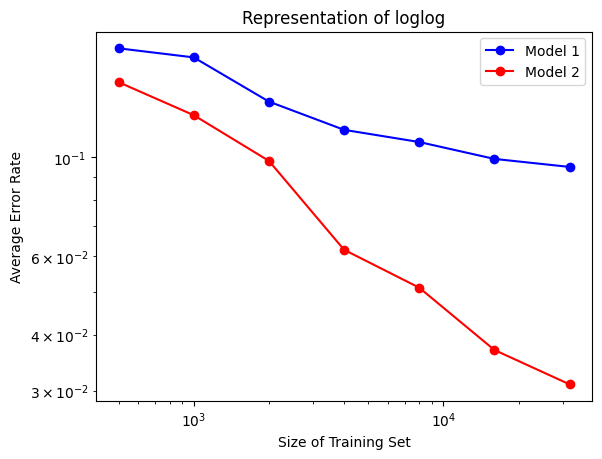

In [18]:
######## 
#THIS IS Q4 PLOT ERROR RATE(LOG) MODEL 1 AND MODEL 2
########

#this cell plot the loglog graph of error rate in respect of different training size.
#trhre computation of is made only on model 2, the result is plotted with the result gained from model 1.

array2 = []
data_Size = [500,1000,2000,4000,8000,16000,32000]
count = 0
dist = []
model2 = MODLE2()
#print(f"best decay in questiuon 3: {best_weight_dacay}")
for dt in data_Size:
    num_epochs = epochsDimention
    train_loader2, val_loader2 = dataset(dt)
    print("dataSize ",dt)
    train_losses2,val_losses2,results2,result_val_error_wd2 = calculationErrorRate3(modle2,train_loader2,val_loader2,num_epochs,best_weight_dacay2)
    tmp2=list(result_val_error_wd2.values())[0]  # Extracts the first (and only) value
    array2.append(tmp2) # add ina array list


#print("list",array)  # Y-axis: Average validation loss
indMin2 = np.where(array2 == np.min(array2))[0]  # Get indices of min value
n = indMin2[0]
#print("THE Min index",indMin[0])
print("The most powerfull dataSize",data_Size[n])

#evaluating the performance by 1/ np.sqrt(dataSize)
for i in range(len(array2)):
    power = 1/np.sqrt(data_Size[i])
    if(power == array2[i]):
        print("most powerFull", array2[i])
    else:
        #dist.append(np.abs(power - array[i]))
        continue
        #print("no equal: ",power)

# Plot the graph
plt.loglog(data_Size, array, marker='o', linestyle='-', color='b', label="Model 1")    
plt.loglog(data_Size, array2, marker='o', linestyle='-', color='r', label="Model 2")


# Labels and title
plt.xlabel("Size of Training Set")
plt.ylabel("Average Error Rate")
plt.title("Representation of loglog")

# Show legend and grid
plt.legend()

# Answer Q4 part 2

The graph shows that the model 2 and model 1 both start more or less at the same point but at the increase of the training set, the distance of two model increase as well. This and clear proof that the model 2 at increase the training set size its error rate decrease more rapidly of the model 2.


CONCLUSION:

This configuaration of the model 2 perform much better than the model 1 with this dataset(in term of overfitting).
